* 6000, 6002, 1171 (국내), 1871 (해외)

## Import

In [81]:
import copy
import numpy as np
from pypfopt import risk_models, exceptions
from pypfopt import EfficientFrontier, CLA
import scipy.cluster.hierarchy as sch
import warnings

import matplotlib.pyplot as plt

plt.style.use("seaborn-deep")

In [82]:
from pypfopt.expected_returns import mean_historical_return, ema_historical_return, capm_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pypfopt
import pandas as pd
import numpy as np
import datetime
import os

plt.rcParams['font.family']="gulim"

* functions

In [106]:
def check(m, S):
    return EfficientFrontier(m, S)

def _plot_io(**kwargs):
    """
    Helper method to optionally save the figure to file.
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param dpi: dpi of figure to save or plot, defaults to 300
    :type dpi: int (between 50-500)
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    """
    filename = kwargs.get("filename", None)
    showfig = kwargs.get("showfig", False)
    dpi = kwargs.get("dpi", 300)

    plt.tight_layout()
    if filename:
        plt.savefig(fname=filename, dpi=dpi)
    if showfig:  # pragma: no cover
        plt.show()


def plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs):
    """
    Generate a basic plot of the covariance (or correlation) matrix, given a
    covariance matrix.
    :param cov_matrix: covariance matrix
    :type cov_matrix: pd.DataFrame or np.ndarray
    :param plot_correlation: whether to plot the correlation matrix instead, defaults to False.
    :type plot_correlation: bool, optional
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    if plot_correlation:
        matrix = risk_models.cov_to_corr(cov_matrix)
    else:
        matrix = cov_matrix
    fig, ax = plt.subplots()

    cax = ax.imshow(matrix)
    fig.colorbar(cax)

    if show_tickers:
        ax.set_xticks(np.arange(0, matrix.shape[0], 1))
        ax.set_xticklabels(matrix.index)
        ax.set_yticks(np.arange(0, matrix.shape[0], 1))
        ax.set_yticklabels(matrix.index)
        plt.xticks(rotation=90)

    _plot_io(**kwargs)

    return ax


def plot_dendrogram(hrp, ax=None, show_tickers=True, **kwargs):
    """
    Plot the clusters in the form of a dendrogram.
    :param hrp: HRPpt object that has already been optimized.
    :type hrp: object
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if hrp.clusters is None:
        warnings.warn(
            "hrp param has not been optimized.  Attempting optimization.",
            RuntimeWarning,
        )
        hrp.optimize()

    if show_tickers:
        sch.dendrogram(hrp.clusters, labels=hrp.tickers, ax=ax, orientation="top")
        ax.tick_params(axis="x", rotation=90)
        plt.tight_layout()
    else:
        sch.dendrogram(hrp.clusters, no_labels=True, ax=ax)

    _plot_io(**kwargs)

    return ax


def _plot_cla(cla, points, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from a CLA object
    """
    if cla.weights is None:
        cla.max_sharpe()
    optimal_ret, optimal_risk, _ = cla.portfolio_performance()

    if cla.frontier_values is None:
        cla.efficient_frontier(points=points)

    mus, sigmas, _ = cla.frontier_values

    ax.plot(sigmas, mus, label="Efficient frontier")
    ax.scatter(optimal_risk, optimal_ret, marker="x", s=100, color="r", label="optimal")

    asset_mu = cla.expected_returns
    asset_sigma = np.sqrt(np.diag(cla.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(cla.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def _ef_default_returns_range(ef, points):
    """
    Helper function to generate a range of returns from the GMV returns to
    the maximum (constrained) returns
    """
    ef_minvol = check(mean_return, S_exp)
    ef_maxret = check(mean_return, S_exp)
    #ef_minvol = copy.deepcopy(ef)
    #ef_maxret = copy.deepcopy(ef)

    ef_minvol.min_volatility()
    min_ret = ef_minvol.portfolio_performance()[0]
    max_ret = ef_maxret._max_return()
    return np.linspace(min_ret, max_ret - 0.0001, points)


def _plot_ef(ef, ef_param, ef_param_range, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from an EfficientFrontier object
    """
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except exceptions.OptimizationError:
            continue
        except ValueError:
            warnings.warn(
                "Could not construct portfolio for parameter value {:.3f}".format(
                    param_value
                )
            )

        ret, sigma, _ = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Efficient frontier")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(ef.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def plot_efficient_frontier(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):
    """
    Plot the efficient frontier based on either a CLA or EfficientFrontier object.
    :param opt: an instantiated optimizer object BEFORE optimising an objective
    :type opt: EfficientFrontier or CLA
    :param ef_param: [EfficientFrontier] whether to use a range over utility, risk, or return.
                     Defaults to "return".
    :type ef_param: str, one of {"utility", "risk", "return"}.
    :param ef_param_range: the range of parameter values for ef_param.
                           If None, automatically compute a range from min->max return.
    :type ef_param_range: np.array or list (recommended to use np.arange or np.linspace)
    :param points: number of points to plot, defaults to 100. This is overridden if
                   an `ef_param_range` is provided explicitly.
    :type points: int, optional
    :param show_assets: whether we should plot the asset risks/returns also, defaults to True
    :type show_assets: bool, optional
    :param show_tickers: whether we should annotate each asset with its ticker, defaults to False
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if isinstance(opt, CLA):
        ax = _plot_cla(
            opt, points, ax=ax, show_assets=show_assets, show_tickers=show_tickers
        )
    elif isinstance(opt, EfficientFrontier):
        if ef_param_range is None:
            ef_param_range = _ef_default_returns_range(opt, points)

        ax = _plot_ef(
            opt,
            ef_param,
            ef_param_range,
            ax=ax,
            show_assets=show_assets,
            show_tickers=show_tickers,
        )
    else:
        raise NotImplementedError("Please pass EfficientFrontier or CLA object")

    ax.legend()
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")

    _plot_io(**kwargs)
    return ax


def plot_weights(weights, ax=None, **kwargs):
    """
    Plot the portfolio weights as a horizontal bar chart
    :param weights: the weights outputted by any PyPortfolioOpt optimizer
    :type weights: {ticker: weight} dict
    :param ax: ax to plot to, optional
    :type ax: matplotlib.axes
    :return: matplotlib axis
    :rtype: matplotlib.axes
    """
    ax = ax or plt.gca()

    desc = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    labels = [i[0] for i in desc]
    vals = [i[1] for i in desc]

    y_pos = np.arange(len(labels))

    ax.barh(y_pos, vals)
    ax.set_xlabel("Weight")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()

    _plot_io(**kwargs)
    return ax

In [107]:
def read_xlsx(name):
    instance = xw.App(visible = False)
    xlsx_data = xw.Book(name).sheets[0]
    df = xlsx_data.range('A1').options(pd.DataFrame, index = False, expand = 'table').value
    instance.quit()
    instance.kill()
    return df

def read_data(name):
    try :
        output = pd.read_excel(name)
    except ValueError:    
        output = read_xlsx(name)
    return output

## Load data

In [3]:
data_path = os.getcwd() + "\\datasets\\"

In [4]:
stock_df = read_data(data_path + "stock_df.xlsx")

In [5]:
port_input = stock_df.iloc[:, 1:]

* Return 계산하기

In [49]:
def get_return(port_input, opt = 'mean'):
    if opt == 'mean':
        output = mean_historical_return(port_input)
    elif opt == 'ema':
        output = ema_historical_return(port_input)
    elif opt == 'capm':
        output = capm_return(port_input)
    elif opt == "price":
        output = returns_from_prices(port_input)
    return output

In [50]:
mean_return = get_return(port_input, 'mean')
ema_return = get_return(port_input, 'ema')
capm_return = get_return(port_input, 'capm')
price_return = get_return(port_input, 'price')

* Risk 계산하기

In [8]:
def get_cov(port_input, opt = 'CovarianceShrinkage-01'):
    if opt == 'CovarianceShrinkage-01':
        S = CovarianceShrinkage(port_input).ledoit_wolf()
    elif opt == 'CovarianceShrinkage-02':
        S = CovarianceShrinkage(port_input).shrunk_covariance()
    elif opt == 'CovarianceShrinkage-03':
        S = CovarianceShrinkage(port_input).oracle_approximating()
    elif opt == "exp_cov":
        S = pypfopt.risk_models.exp_cov(port_input)
    elif opt == "semicovariance":
        S = pypfopt.risk_models.semicovariance(port_input)
    return S

In [9]:
cs_01 = get_cov(port_input, opt = 'CovarianceShrinkage-01')
cs_02 = get_cov(port_input, opt = 'CovarianceShrinkage-02')
cs_03 = get_cov(port_input, opt = 'CovarianceShrinkage-03')
S_exp = get_cov(port_input, opt = 'exp_cov')
S_semi = get_cov(port_input, opt = 'semicovariance')

* etf list 정리

In [17]:
etf_df = fdr.StockListing("ETF/KR")
etf_list =[x for x in port_input.columns if x in list(etf_df.Name)]

cate = ["etf" if x in etf_list else "stock" for x in port_input.columns]
sector_dict = {x:y for x,y in zip(port_input.columns, cate)}

get_lower = None
get_upper = 0.2

lower_dict = {}
upper_dict = {"etf":get_upper}

* EfficientFrontier

In [84]:
def mvo(ef, method = "max_sharpe"):
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    elif method == "min_volatility":
        weights = ef.min_volatility()
    elif method == "max_quadratic_utility":
        weights = ef.max_quadratic_utility()
    return weights

In [220]:
ef = EfficientFrontier(mean_return, S_semi)
#ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
#ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=2)
weights = mvo(ef, 'max_sharpe')

In [163]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'min_volatility')

In [87]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'max_quadratic_utility')

In [ ]:
# maximises return for a given target risk
ef.efficient_risk(0.08)

In [159]:
# minimises risk for a given target return
ef.efficient_return(0.08)

OrderedDict([('JW중외제약', 0.0),
             ('KODEX 미국S&P500TR', 0.7967061813029677),
             ('KODEX 코스피TR', 0.1940972981123119),
             ('LG전자', 0.0),
             ('NAVER', 0.0),
             ('OCI', 0.0),
             ('SK바이오사이언스', 0.0),
             ('SK하이닉스', 0.0),
             ('STX', 0.0),
             ('고려신용정보', 0.0024565607460521),
             ('삼성전자', 0.0),
             ('삼천리자전거', 0.0),
             ('씨티케이', 0.0),
             ('아프리카TV', 0.0),
             ('카카오', 0.0),
             ('카카오페이', 0.0),
             ('피씨엘', 0.0),
             ('한탑', 0.0),
             ('애플', 0.000292825550784),
             ('알파벳 A주', 0.0064471342878842),
             ('메타 플랫폼스(페이스북)', 0.0),
             ('엔비디아', 0.0),
             ('퀄컴', 0.0),
             ('AMD', 0.0)])

In [221]:
# (expected return, volatility, sharpe ratio) for the optimized portfolio
ef.portfolio_performance()

(0.10744064523165449, 0.021706639832689216, 4.028290233109817)

* risk parity optimization

In [45]:
rp = pypfopt.hierarchical_portfolio.HRPOpt(price_return, S_semi)

In [48]:
rp.optimize()

OrderedDict([('AMD', 0.01367680552642929),
             ('JW중외제약', 0.025890068959592012),
             ('KODEX 미국S&P500TR', 0.21323336378241783),
             ('KODEX 코스피TR', 0.1563560599401391),
             ('LG전자', 0.04099825779722364),
             ('NAVER', 0.029190559128935156),
             ('OCI', 0.02228706665997298),
             ('SK바이오사이언스', 0.014044596197573764),
             ('SK하이닉스', 0.016537343315960615),
             ('STX', 0.022388476141968938),
             ('고려신용정보', 0.057002205921041514),
             ('메타 플랫폼스(페이스북)', 0.04916573680352075),
             ('삼성전자', 0.032645326154425565),
             ('삼천리자전거', 0.020240420988156965),
             ('씨티케이', 0.04380243500970432),
             ('아프리카TV', 0.03378837592754709),
             ('알파벳 A주', 0.06317489870156899),
             ('애플', 0.022222588958519713),
             ('엔비디아', 0.013559320493879298),
             ('카카오', 0.020635489457276973),
             ('카카오페이', 0.016411474304476672),
             ('퀄컴', 0.03

In [83]:
rp.portfolio_performance()

(0.13545626991592824, 0.1499549377461645, 0.7699397675811535)

* general efficient frontier

In [24]:
from pypfopt import expected_returns, EfficientSemivariance

In [31]:
mu = mean_historical_return(port_input)
historical_returns = returns_from_prices(port_input)
es = EfficientSemivariance(mu, historical_returns)

In [37]:
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('JW중외제약', 0.0), ('KODEX 미국S&P500TR', 0.0), ('KODEX 코스피TR', 0.0), ('LG전자', 0.0), ('NAVER', 0.21894), ('OCI', 0.0), ('SK바이오사이언스', 0.0), ('SK하이닉스', 0.0), ('STX', 0.0), ('고려신용정보', 0.07886), ('삼성전자', 0.30942), ('삼천리자전거', 0.0), ('씨티케이', 0.0), ('아프리카TV', 0.0), ('카카오', 0.0), ('카카오페이', 0.0), ('피씨엘', 0.0), ('한탑', 0.01436), ('애플', 0.25152), ('알파벳 A주', 0.12691), ('메타 플랫폼스(페이스북)', 0.0), ('엔비디아', 0.0), ('퀄컴', 0.0), ('AMD', 0.0)])
Expected annual return: 20.0%
Annual semi-deviation: 12.1%
Sortino Ratio: 1.48


(0.20000000000000004, 0.12148081674617818, 1.4817154248813766)

* plotting

<AxesSubplot:xlabel='Weight'>

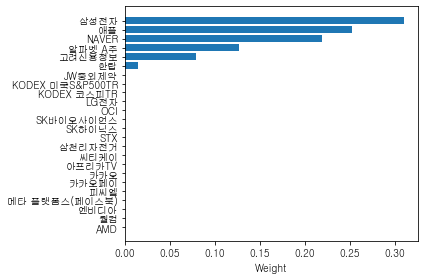

In [76]:
plot_weights(weights)

In [121]:
ef = EfficientFrontier(mean_return, S_semi)
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()

ef_minvol = EfficientFrontier(mean_return, S_semi)
ef_maxret = EfficientFrontier(mean_return, S_semi)

ef_minvol.min_volatility()
min_ret = ef_minvol.portfolio_performance()[0]
max_ret = ef_maxret._max_return()
np.linspace(min_ret, max_ret - 0.0001, 100)

array([0.08304012, 0.08493367, 0.08682721, 0.08872075, 0.0906143 ,
       0.09250784, 0.09440139, 0.09629493, 0.09818847, 0.10008202,
       0.10197556, 0.1038691 , 0.10576265, 0.10765619, 0.10954973,
       0.11144328, 0.11333682, 0.11523036, 0.11712391, 0.11901745,
       0.12091099, 0.12280454, 0.12469808, 0.12659163, 0.12848517,
       0.13037871, 0.13227226, 0.1341658 , 0.13605934, 0.13795289,
       0.13984643, 0.14173997, 0.14363352, 0.14552706, 0.1474206 ,
       0.14931415, 0.15120769, 0.15310123, 0.15499478, 0.15688832,
       0.15878187, 0.16067541, 0.16256895, 0.1644625 , 0.16635604,
       0.16824958, 0.17014313, 0.17203667, 0.17393021, 0.17582376,
       0.1777173 , 0.17961084, 0.18150439, 0.18339793, 0.18529147,
       0.18718502, 0.18907856, 0.19097211, 0.19286565, 0.19475919,
       0.19665274, 0.19854628, 0.20043982, 0.20233337, 0.20422691,
       0.20612045, 0.208014  , 0.20990754, 0.21180108, 0.21369463,
       0.21558817, 0.21748171, 0.21937526, 0.2212688 , 0.22316

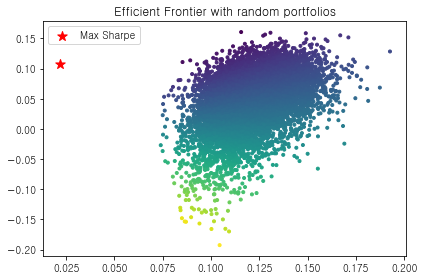

In [122]:
fig, ax = plt.subplots()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")


# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [225]:
weight_dict = pd.DataFrame.from_dict(weights, orient = 'index', columns=['weights'])
temp_weight = weight_dict.loc[weight_dict.weights != 0]
temp_price = price_return.loc[:, temp_weight.index]
temp_weight

,weights
KODEX 미국S&P500TR,0.939254
NAVER,0.008851
삼성전자,0.006489
애플,0.000353
알파벳 A주,0.044167
퀄컴,0.000885


In [226]:
np.sum(np.array(temp_price.sum(axis = 0)) * np.array(temp_weight['weights']))

0.4653795392353111

In [229]:
for col in temp_price.columns:
    temp_price[col] = temp_price[col] * temp_weight.loc[col,'weights']

temp_price.sum(axis = 1).sum()

0.4653795392353111

* pyfolio

In [149]:
from quantrocket.zipline import ZiplineBacktestResult

import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

In [124]:
bt = ZiplineBacktestResult.from_csv('https://raw.githubusercontent.com/quantrocket-codeload/quant-finance-lectures/master/quant_finance_lectures/Lecture33-Backtest-Results.csv')

In [142]:
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions

In [143]:
print("The Sharpe Ratio of the backtest is: ", empyrical.sharpe_ratio(bt_returns))

The Sharpe Ratio of the backtest is:  1.543354454834436


In [144]:
print("The market beta of the backtest is: ", empyrical.beta(bt_returns,benchmark_rets))

The market beta of the backtest is:  0.5516223402218898


In [145]:
print("The maxmimum drawdown of the backtest is: ", empyrical.max_drawdown(bt_returns))

The maxmimum drawdown of the backtest is:  -0.04906836872744358


In [146]:
bt_returns.index

DatetimeIndex(['2013-01-02 00:00:00+00:00', '2013-01-03 00:00:00+00:00',
               '2013-01-04 00:00:00+00:00', '2013-01-07 00:00:00+00:00',
               '2013-01-08 00:00:00+00:00', '2013-01-09 00:00:00+00:00',
               '2013-01-10 00:00:00+00:00', '2013-01-11 00:00:00+00:00',
               '2013-01-14 00:00:00+00:00', '2013-01-15 00:00:00+00:00',
               ...
               '2013-12-17 00:00:00+00:00', '2013-12-18 00:00:00+00:00',
               '2013-12-19 00:00:00+00:00', '2013-12-20 00:00:00+00:00',
               '2013-12-23 00:00:00+00:00', '2013-12-24 00:00:00+00:00',
               '2013-12-26 00:00:00+00:00', '2013-12-27 00:00:00+00:00',
               '2013-12-30 00:00:00+00:00', '2013-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=252, freq=None)

In [147]:
benchmark_rets.index

DatetimeIndex(['2013-01-03 00:00:00+00:00', '2013-01-04 00:00:00+00:00',
               '2013-01-07 00:00:00+00:00', '2013-01-08 00:00:00+00:00',
               '2013-01-09 00:00:00+00:00', '2013-01-10 00:00:00+00:00',
               '2013-01-11 00:00:00+00:00', '2013-01-14 00:00:00+00:00',
               '2013-01-15 00:00:00+00:00', '2013-01-16 00:00:00+00:00',
               ...
               '2013-12-17 00:00:00+00:00', '2013-12-18 00:00:00+00:00',
               '2013-12-19 00:00:00+00:00', '2013-12-20 00:00:00+00:00',
               '2013-12-23 00:00:00+00:00', '2013-12-24 00:00:00+00:00',
               '2013-12-26 00:00:00+00:00', '2013-12-27 00:00:00+00:00',
               '2013-12-30 00:00:00+00:00', '2013-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=251, freq=None)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


<AxesSubplot:xlabel='date', ylabel='Cumulative returns'>

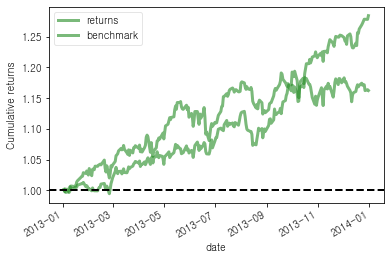

In [274]:
pf.plotting.plot_rolling_returns(pd.concat([bt_returns, benchmark_rets], axis = 1))

In [ ]:
# Cumulative Returns
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(bt_returns[:-1], benchmark_rets)

In [ ]:
# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_returns)
plt.tight_layout()

In [81]:
# how to calculate?
# benchmark_period_return == s&p500 return인지 봐보자
bt.perf

column,algorithm_period_return,benchmark_period_return,capital_used,ending_cash,ending_exposure,ending_value,excess_return,gross_leverage,long_exposure,long_value,...,starting_value,trading_days,transactions,treasury_period_return,algo_volatility,alpha,benchmark_volatility,beta,sharpe,sortino
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,0.001793,0.025633,-4190.9000,9.958091e+05,5983.565,5983.565,0.0,0.989466,498611.709,498611.709,...,0.000,1,"[{'amount': 190, 'dt': Timestamp('2013-01-02 1...",0.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03 00:00:00+00:00,-0.001922,0.023343,-224.7380,9.955844e+05,2493.335,2493.335,0.0,0.991728,496157.325,496157.325,...,5983.565,2,"[{'amount': -185, 'dt': Timestamp('2013-01-03 ...",0.0,0.061748,-0.561676,0.312781,0.197417,-3.908968,-5.798630
2013-01-04 00:00:00+00:00,-0.003388,0.027808,-1537.0310,9.940473e+05,2564.594,2564.594,0.0,1.003104,501135.227,501135.227,...,2493.335,3,"[{'amount': -81, 'dt': Timestamp('2013-01-04 1...",0.0,0.043913,-0.513482,0.231168,0.186601,-6.473649,-7.776581
2013-01-07 00:00:00+00:00,-0.002428,0.024998,-1598.3320,9.924490e+05,5122.731,5122.731,0.0,1.002880,502783.826,502783.826,...,2564.594,4,"[{'amount': -108, 'dt': Timestamp('2013-01-07 ...",0.0,0.039510,-0.282244,0.211377,0.113438,-3.860633,-4.818195
2013-01-08 00:00:00+00:00,0.003570,0.022045,-445.1670,9.920038e+05,11566.590,11566.590,0.0,0.995215,505167.396,505167.396,...,5122.731,5,"[{'amount': 136, 'dt': Timestamp('2013-01-08 1...",0.0,0.058126,0.171992,0.194213,0.019966,3.114668,6.393692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24 00:00:00+00:00,0.171033,0.304667,-4137.7850,1.056067e+06,114965.902,114965.902,0.0,1.236909,781713.563,781713.563,...,114164.417,248,"[{'amount': 263, 'dt': Timestamp('2013-12-24 1...",0.0,0.101290,0.019757,0.111683,0.527934,1.634817,2.465909
2013-12-26 00:00:00+00:00,0.171839,0.311264,-11688.5804,1.044378e+06,127460.635,127460.635,0.0,1.245473,793477.325,793477.325,...,114965.902,249,"[{'amount': -71, 'dt': Timestamp('2013-12-26 1...",0.0,0.101086,0.017824,0.111529,0.527271,1.638437,2.471349
2013-12-27 00:00:00+00:00,0.162336,0.311193,11775.3510,1.056153e+06,106182.080,106182.080,0.0,1.250686,779949.625,779949.625,...,127460.635,250,"[{'amount': -1271, 'dt': Timestamp('2013-12-27...",0.0,0.101266,0.009278,0.111311,0.528045,1.548258,2.327000


In [248]:
9.958091e+05

995809.1

In [259]:
100*0.012

1.2

In [262]:
1922/1000000

0.001922

In [265]:
3714.968 * (1000000/1922)

1932865.7648283036

In [270]:
-3714.968/1001792.665

-0.003708320224125418

In [269]:
bt.perf.loc[bt.perf.index == '2013-01-03 00:00:00+00:00'].T

date,2013-01-03 00:00:00+00:00
column,
algorithm_period_return,-0.001922
benchmark_period_return,0.023343
capital_used,-224.738
ending_cash,995584.362
ending_exposure,2493.335
ending_value,2493.335
excess_return,0.0
gross_leverage,0.991728
long_exposure,496157.325


In [247]:
bt.perf.columns

Index(['algorithm_period_return', 'benchmark_period_return', 'capital_used',
       'ending_cash', 'ending_exposure', 'ending_value', 'excess_return',
       'gross_leverage', 'long_exposure', 'long_value', 'longs_count',
       'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'returns', 'short_exposure', 'short_value', 'shorts_count',
       'starting_cash', 'starting_exposure', 'starting_value', 'trading_days',
       'transactions', 'treasury_period_return', 'algo_volatility', 'alpha',
       'benchmark_volatility', 'beta', 'sharpe', 'sortino'],
      dtype='object', name='column')

In [68]:
bt_returns

date
2013-01-02 00:00:00+00:00    0.001793
2013-01-03 00:00:00+00:00   -0.003708
2013-01-04 00:00:00+00:00   -0.001469
2013-01-07 00:00:00+00:00    0.000963
2013-01-08 00:00:00+00:00    0.006013
                               ...   
2013-12-24 00:00:00+00:00   -0.002841
2013-12-26 00:00:00+00:00    0.000688
2013-12-27 00:00:00+00:00   -0.008110
2013-12-30 00:00:00+00:00    0.001283
2013-12-31 00:00:00+00:00   -0.001132
Name: returns, Length: 252, dtype: float64

In [ ]:
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions

In [231]:
benchmark_rets

date
2013-01-03 00:00:00+00:00   -0.002232
2013-01-04 00:00:00+00:00    0.004363
2013-01-07 00:00:00+00:00   -0.002734
2013-01-08 00:00:00+00:00   -0.002881
2013-01-09 00:00:00+00:00    0.002547
                               ...   
2013-12-24 00:00:00+00:00    0.002191
2013-12-26 00:00:00+00:00    0.005057
2013-12-27 00:00:00+00:00   -0.000054
2013-12-30 00:00:00+00:00   -0.000136
2013-12-31 00:00:00+00:00    0.004733
Name: benchmark, Length: 251, dtype: float64

In [237]:
a = bt_transactions.loc[bt_transactions.index == '2013-01-02 15:31:00+00:00']

In [238]:
a.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [80]:
a.groupby("sid")['amount'].sum()

sid
Equity(FIBBG000B9WJ73 [ARCH])    -681
Equity(FIBBG000BB2KW0 [APOL])    -237
Equity(FIBBG000BB8ZF0 [WNR])      176
Equity(FIBBG000BB9RZ5 [SHAW])     106
Equity(FIBBG000BBQCY0 [AMD])    -1992
                                 ... 
Equity(FIBBG00FZYFVC5 [DK])       192
Equity(FIBBG00JPR7Y81 [HPR])     -280
Equity(FIBBG00JSKYMY0 [BSMX])    -306
Equity(FIBBG00NNG33D4 [GTAT])   -1545
Equity(QI000000052980 [LGF])      295
Name: amount, Length: 189, dtype: int64

In [249]:
a.txn_dollars.sum() / 995809.1

-0.03408385101120299

In [65]:
bt_transactions.loc[bt_transactions.symbol == 'Equity(FIBBG000BCJ161 [SRPT])']

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.25,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.5
2013-10-07 14:31:00+00:00,-190,6820a600b4ca4bb0bd99cf8097827a74,54.04,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),10267.6


In [67]:
190*26.25

4987.5

In [66]:
bt_positions.loc[:, ['Equity(FIBBG000BCJ161 [SRPT])']]

column,Equity(FIBBG000BCJ161 [SRPT])
date,
2013-01-02 00:00:00+00:00,4987.5
2013-01-03 00:00:00+00:00,5348.5
2013-01-04 00:00:00+00:00,5496.7
2013-01-07 00:00:00+00:00,5492.9
2013-01-08 00:00:00+00:00,5363.7
...,...
2013-12-24 00:00:00+00:00,0.0
2013-12-26 00:00:00+00:00,0.0
2013-12-27 00:00:00+00:00,0.0
